# Running in Google Colab

You can run this notebook online in Google Colab, by clicking in the "Open in Colab" button below.

Just remeber to setup the [Connecting to IRIS Database](#Connecting-to-IRIS-Database) before run the notebook.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jrpereirajr/intersystems-iris-notebooks/blob/main/cloud_sql/star_classification/Star%20Classification%20(Classification%20-%20Multi%20Classes).ipynb)

In [1]:
# Download the datasets for this notebook to make sure that they are available
import requests
urls = [
    "https://raw.githubusercontent.com/jrpereirajr/intersystems-iris-notebooks/main/cloud_sql/star_classification/starclassification_train.csv",
    "https://raw.githubusercontent.com/jrpereirajr/intersystems-iris-notebooks/main/cloud_sql/star_classification/starclassification_validate.csv"
]
for url in urls:
  file_name = url.split("/")[-1]
  r = requests.get(url, allow_redirects=True)
  print(f"File size ({file_name}): {open(f'./{file_name}', 'wb').write(r.content)} bytes")

File size (starclassification_train.csv): 1819848 bytes
File size (starclassification_validate.csv): 1017543 bytes


# Installation

These instructions will install the needed libraries and run the code on your local environment.

## Installing sqlalchemy-iris
The following code install the sqlalchemy-iris library - an InterSystems IRIS dialect for SQLAlchemy.

In [2]:
!pip install sqlalchemy-iris


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Installing Additional Libraries
Other libraries such as pandas, numpy, and more are essential for data manipulation and visualization:

In [3]:
!pip install pandas numpy matplotlib scikit-learn==1.3.1


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Setting up InterSystems Cloud SQL with IntegratedML
To set up an InterSystems Cloud SQL instance integrated with IntegratedML, follow the instructions provided in the linked notebook:

Refer to [this notebook](../cloud-sql-instruct/InterSystems%20IntegratedML%20Cloud%20SQL.ipynb) to see how to get access to IntegratedML.

# Imports

In [4]:
# Required libraries
from sqlalchemy import create_engine, text, DateTime
import pandas as pd
import numpy as np
import ssl
import os
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

# Connecting to IRIS Database
This section shows how to establish a connection to the InterSystems IRIS database.

⚠️ Remember to setup your InterSystems Cloud SQL credentials! You can setup by hardcoding or by environment variables. ⚠️ 

In [5]:
# InterSystems IRIS Cloud SQL connection parameters
args = {
    'hostname': os.getenv("ISC_CLOUD_SQL_HOSTNAME") or "<put-the-hostname-here>", 
    'port': os.getenv("ISC_CLOUD_SQL_PORT")  or "<put-the-port-here>",
    'namespace': os.getenv("ISC_CLOUD_SQL_NAMESPACE") or "USER", 
    'username': os.getenv("ISC_CLOUD_SQL_USER") or "<put-the-user-here>",  
    'password': os.getenv("ISC_CLOUD_SQL_PWD")  or "<put-the-password-here>"
}

In [6]:
# PEM file contents as string
pem_file_contents = os.getenv("ISC_CLOUD_SQL_X509_CERT") or """
<put-the-X.509-certificate-here>
"""
    
# create the ssl context from the certificate
ssl_context = ssl.create_default_context(cadata=pem_file_contents)

In [7]:
# Create a sqlalchemy connection to IRIS
engine = create_engine(f"iris://{args['username']}:{args['password']}@{args['hostname']}:{args['port']}/{args['namespace']}", connect_args={'sslcontext':ssl_context})
conn = engine.connect()

C:\Users\jrper\dev\venv\Lib\site-packages\sqlalchemy_iris\base.py:888: SAWarning: There are no access to %Dictionary, may be required for some advanced features, such as Calculated fields, and include columns in indexes                
  util.warn(


# Data ingestion
This part deals with data preparation, specifically reading and ingesting data into the IRIS database:

In [8]:
# Set pandas to display all columns; default is 20
pd.options.display.max_columns = None

In [9]:
# Load the trainning dataset from the CSV file, enforcing pandas to interpret columns tpep_pickup_datetime and tpep_dropoff_datetime as timestramp
train_df = pd.read_csv(
    "./starclassification_train.csv",
    dtype={
        "spec_obj_ID": "object" # pandas infers the uint64 type but IRIS doesn't support such a type, so cast it to string due it's just and ID
    }
)
train_df

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237660e+18,213.163547,57.128794,19.51442,19.65477,19.52003,19.38459,19.38385,3225,301,4,50,7.65965E+18,QSO,1.387801,6803,56402,558
1,1.237670e+18,189.027597,32.651741,25.59192,20.65455,19.00360,18.35878,17.95515,4599,301,4,124,7.29823E+18,GALAXY,0.322277,6482,56358,536
2,1.237660e+18,132.349124,54.907833,23.28531,20.94033,19.62684,18.90887,18.57924,3600,301,2,19,8.19224E+18,STAR,0.000167,7276,57061,703
3,1.237660e+18,233.298370,34.827388,24.63465,22.14582,20.46511,20.69813,22.77940,3723,301,1,67,1.20945E+19,STAR,-0.000078,10742,58198,376
4,1.237670e+18,227.570639,57.602172,19.59640,19.60486,19.62648,19.39641,19.23944,6162,301,3,26,7.65071E+18,QSO,1.953817,6795,56425,786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13097,1.237670e+18,204.836333,0.770354,23.66083,22.58946,21.02837,20.14394,19.69193,6166,301,2,101,4.55095E+18,GALAXY,0.579244,4042,55626,243
13098,1.237660e+18,333.699183,0.053602,19.22506,17.52021,16.73728,16.40961,16.20801,4192,301,4,180,3.54222E+18,STAR,0.000055,3146,54773,512
13099,1.237660e+18,336.457941,0.020894,17.61952,16.42450,15.92927,15.69450,15.66591,4192,301,4,199,1.28692E+18,STAR,-0.000228,1143,52619,72
13100,1.237660e+18,331.705221,0.040792,21.29984,19.88600,19.29039,18.93517,18.72525,4192,301,4,167,1.66E+18,STAR,-0.001092,1475,52903,496


In [10]:
# Display basic statistics of the training dataset
train_df.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,redshift,plate,MJD,fiber_ID
count,1.310200e+04,13102.000000,13102.000000,13102.000000,13102.000000,13102.000000,13102.000000,13102.000000,13102.000000,13102.0,13102.000000,13102.000000,13102.000000,13102.000000,13102.000000,13102.000000
mean,1.237689e+18,184.889175,22.882990,22.133732,20.660774,19.656103,19.085411,18.767245,4503.278583,301.0,3.677377,197.156312,0.560292,5067.207907,55533.447871,456.415204
std,2.394358e+14,96.603213,19.776959,2.255585,2.035029,1.841366,1.738481,1.744616,1921.327668,0.0,1.507867,160.847166,0.721778,2972.158220,1830.077164,267.712119
min,1.237650e+18,0.025716,-12.511225,13.897990,12.952380,12.338230,12.129100,11.848380,307.000000,301.0,1.000000,11.000000,-0.006055,266.000000,51608.000000,1.000000
25%,1.237660e+18,130.898282,3.028822,20.376965,18.992777,18.163325,17.775615,17.498695,3225.000000,301.0,2.000000,92.000000,0.047149,2444.000000,54139.000000,234.250000
50%,1.237660e+18,183.135380,20.945582,22.292870,21.129140,20.093780,19.374145,18.976240,4192.000000,301.0,4.000000,158.000000,0.421559,4970.000000,55865.000000,447.000000
75%,1.237670e+18,237.140467,39.269979,23.746502,22.174540,21.046705,20.360890,19.889415,5934.000000,301.0,5.000000,243.000000,0.693623,7278.000000,56717.000000,640.000000
max,1.240000e+18,359.999615,83.000519,27.851840,27.072670,25.606610,25.008740,28.238290,8162.000000,301.0,6.000000,941.000000,7.011245,12547.000000,58932.000000,1000.000000


In [11]:
# Uses the sqlalchmey connection to create a table in InterSystems IRIS Cloud SQL and ingest the training dataset
train_df.to_sql(
    name='starclassification_train', # the table name that is going to be created in IRIS
    con=conn, 
    if_exists='replace', 
    index=False
)

-1

In [12]:
# Check how many records was ingested in IRIS database
# Note the use of the default IRIS schema SQLUser, 
# as we didn't define a schema when ingesting the dataset into a table in IRIS
sql_query = f"""
SELECT count(*) from SQLUser.starclassification_train
"""
result = conn.execute(text(sql_query))
print(f"Imported {result.first()[0]} records")

Imported 13102 records


In [13]:
# Retrive the first and last 5 records from the trainning dataset ingested in IRIS
sql = f"""
select top 5 * from SQLUser.starclassification_train order by ID
union
select top 5 * from SQLUser.starclassification_train order by ID desc
"""
pd.read_sql(text(sql), conn)

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237660e+18,213.163547,57.128794,19.51442,19.65477,19.52003,19.38459,19.38385,3225,301,4,50,7.65965E+18,QSO,1.387801,6803,56402,558
1,1.237670e+18,189.027597,32.651741,25.59192,20.65455,19.00360,18.35878,17.95515,4599,301,4,124,7.29823E+18,GALAXY,0.322277,6482,56358,536
2,1.237660e+18,132.349124,54.907833,23.28531,20.94033,19.62684,18.90887,18.57924,3600,301,2,19,8.19224E+18,STAR,0.000167,7276,57061,703
3,1.237660e+18,233.298370,34.827388,24.63465,22.14582,20.46511,20.69813,22.77940,3723,301,1,67,1.20945E+19,STAR,-0.000078,10742,58198,376
4,1.237670e+18,227.570639,57.602172,19.59640,19.60486,19.62648,19.39641,19.23944,6162,301,3,26,7.65071E+18,QSO,1.953817,6795,56425,786
5,1.237660e+18,340.667864,0.125230,21.11650,20.09529,19.79470,19.78815,19.52723,4192,301,4,227,4.73456E+18,QSO,2.460201,4205,55454,534
6,1.237660e+18,331.705221,0.040792,21.29984,19.88600,19.29039,18.93517,18.72525,4192,301,4,167,1.66E+18,STAR,-0.001092,1475,52903,496
7,1.237660e+18,336.457941,0.020894,17.61952,16.42450,15.92927,15.69450,15.66591,4192,301,4,199,1.28692E+18,STAR,-0.000228,1143,52619,72
8,1.237660e+18,333.699183,0.053602,19.22506,17.52021,16.73728,16.40961,16.20801,4192,301,4,180,3.54222E+18,STAR,0.000055,3146,54773,512
9,1.237670e+18,204.836333,0.770354,23.66083,22.58946,21.02837,20.14394,19.69193,6166,301,2,101,4.55095E+18,GALAXY,0.579244,4042,55626,243


In [14]:
# Load the validation dataset from the CSV file
validate_df = pd.read_csv(
    "./starclassification_validate.csv",
    dtype={
        "spec_obj_ID": "object" # pandas infers the uint64 type but IRIS doesn't support such a type, so cast it to string due it's just and ID
    }
)
validate_df

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1237660000000000000,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6543780000000000000,GALAXY,0.634794,5812,56354,171
1,1237660000000000000,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,11760100000000000000,GALAXY,0.779136,10445,58158,427
2,1237660000000000000,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5152200000000000000,GALAXY,0.644195,4576,55592,299
3,1237660000000000000,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,10301100000000000000,GALAXY,0.932346,9149,58039,775
4,1237680000000000000,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6891860000000000000,GALAXY,0.116123,6121,56187,842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6597,1237670000000000000,195.763037,19.198394,17.95075,17.02786,16.66760,16.53671,16.53282,5308,301,2,30,6597840000000000000,STAR,-0.000081,5860,56046,248
6598,1237670000000000000,136.302097,16.983044,24.04573,21.82140,20.21430,19.41293,19.09047,5125,301,3,55,5963930000000000000,GALAXY,0.454335,5297,55913,147
6599,1237670000000000000,135.473761,16.822349,23.95959,22.41430,21.51976,21.02791,20.42962,5125,301,3,50,10753500000000000000,GALAXY,0.827429,9551,57801,112
6600,1237650000000000000,188.055025,-2.250818,19.03538,17.49085,16.65012,16.25826,15.94257,1140,301,4,235,377275000000000000,GALAXY,0.111191,335,52000,358


In [15]:
validate_df.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,redshift,plate,MJD,fiber_ID
count,6.602000e+03,6602.000000,6602.000000,6602.000000,6602.000000,6602.000000,6602.000000,6602.000000,6602.000000,6602.0,6602.000000,6602.000000,6602.000000,6602.000000,6602.000000,6602.000000
mean,1.237691e+18,177.533473,23.828466,22.001928,20.585782,19.632626,19.095290,18.793460,4507.967586,301.0,3.563466,189.614359,0.571406,5072.047410,55557.432293,451.186762
std,2.476816e+14,96.804527,19.354436,2.223296,2.026451,1.855590,1.778529,1.798905,1985.306468,0.0,1.566092,151.664464,0.731069,2943.645516,1806.938221,268.726097
min,1.237650e+18,0.022966,-16.778968,14.151990,10.730970,9.822070,9.469903,9.612333,109.000000,301.0,1.000000,11.000000,-0.006863,267.000000,51608.000000,1.000000
25%,1.237660e+18,125.649508,4.470455,20.287345,18.952568,18.089377,17.702040,17.431313,3225.000000,301.0,2.000000,84.000000,0.040465,2431.000000,54180.000000,229.000000
50%,1.237660e+18,177.819470,23.021161,22.053640,21.017725,20.106565,19.425660,19.034415,4263.000000,301.0,4.000000,151.000000,0.390938,4854.000000,55856.000000,438.000000
75%,1.237670e+18,235.400696,39.400985,23.586795,22.063198,21.043430,20.428535,19.966528,5598.000000,301.0,5.000000,243.000000,0.710663,7378.000000,56748.000000,647.000000
max,1.240000e+18,359.998965,82.567500,27.764940,31.602240,27.334760,24.942000,24.393310,8162.000000,301.0,6.000000,844.000000,6.706752,12547.000000,58932.000000,1000.000000


In [16]:
# Ingest the validating dataset into InterSystems IRIS Cloud SQL
validate_df.to_sql(
    name='starclassification_validate', # the table name that is going to be created in IRIS
    con=conn, 
    if_exists='replace', 
    index=False)

-1

In [17]:
# Check how many records was ingested in IRIS database
sql_query = f"""
SELECT count(*) from SQLUser.starclassification_validate
"""
result = conn.execute(text(sql_query))
print(f"Imported {result.first()[0]} records")

Imported 6602 records


In [18]:
# Retrive the first and last 5 records from the validation dataset ingested in IRIS
sql = f"""
SELECT top 5 * from SQLUser.starclassification_validate order by ID
union
SELECT top 5 * from SQLUser.starclassification_validate order by ID desc
"""
pd.read_sql(text(sql), conn)

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1237660000000000000,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6543780000000000000,GALAXY,0.634794,5812,56354,171
1,1237660000000000000,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,11760100000000000000,GALAXY,0.779136,10445,58158,427
2,1237660000000000000,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5152200000000000000,GALAXY,0.644195,4576,55592,299
3,1237660000000000000,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,10301100000000000000,GALAXY,0.932346,9149,58039,775
4,1237680000000000000,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6891860000000000000,GALAXY,0.116123,6121,56187,842
5,1237660000000000000,181.548453,49.863851,19.27924,18.23704,17.90141,17.76726,17.72121,2964,301,3,307,3286550000000000000,STAR,0.000483,2919,54537,192
6,1237650000000000000,188.055025,-2.250818,19.03538,17.49085,16.65012,16.25826,15.94257,1140,301,4,235,377275000000000000,GALAXY,0.111191,335,52000,358
7,1237670000000000000,135.473761,16.822349,23.95959,22.41430,21.51976,21.02791,20.42962,5125,301,3,50,10753500000000000000,GALAXY,0.827429,9551,57801,112
8,1237670000000000000,136.302097,16.983044,24.04573,21.82140,20.21430,19.41293,19.09047,5125,301,3,55,5963930000000000000,GALAXY,0.454335,5297,55913,147
9,1237670000000000000,195.763037,19.198394,17.95075,17.02786,16.66760,16.53671,16.53282,5308,301,2,30,6597840000000000000,STAR,-0.000081,5860,56046,248


# Create your model

In [19]:
# Make sure that there is no previous ML model in IRIS called StarClassification
sql = """
drop model StarClassification
"""
try:
    result = conn.execute(text(sql))
    print("Model removed.")
except:
    print("Can't drop the model - probably it doesn't exist.")

Can't drop the model - probably it doesn't exist.


In [20]:
# Tells IRIS to create a ML model called 'StarClassification' to predict the value of the target column 'class', 
# based on features (columns) within the training table 'SQLUser.starclassification_train'.
# For more information: https://docs.intersystems.com/irislatest/csp/docbook/DocBook.UI.Page.cls?KEY=GIML_Basics#GIML_Basics_Create
sql = """
create model StarClassification predicting (class) from SQLUser.starclassification_train
"""
conn.execute(text(sql))

In [21]:
# Search for the create ML model hosted in IRIS
# For more information: https://docs.intersystems.com/irislatest/csp/docbook/DocBook.UI.Page.cls?KEY=GIML_Maintain#GIML_Using_Maintain_View_Models
sql = """
select * from INFORMATION_SCHEMA.ML_MODELS where MODEL_NAME = 'StarClassification'
"""
pd.read_sql(text(sql), conn)

,MODEL_NAME,DESCRIPTION,PREDICTING_COLUMN_NAME,PREDICTING_COLUMN_TYPE,WITH_COLUMNS,CREATE_TIMESTAMP,DEFAULT_TRAINED_MODEL_NAME,DEFAULT_SETTINGS,DEFAULT_TRAINING_QUERY
0,StarClassification,Model StarClassification created via SQL by us...,class,VARCHAR,"obj_ID:DOUBLE, alpha:DOUBLE, delta:DOUBLE, u:D...",2023-11-02 15:51:51.257,None,None,SELECT * FROM SQLUser . starclassification_train


# Train your model

In [22]:
# Let IRIS train the StarClassification ML model using the tranning dataset SQLUser.starclassification_train 
# and label it as StarClassificationTranined
# For more information: https://docs.intersystems.com/irislatest/csp/docbook/DocBook.UI.Page.cls?KEY=GIML_Basics#GIML_Basics_Train
sql = """
train model StarClassification as StarClassificationTranined
"""
conn.execute(text(sql))

In [23]:
# Get information about trannings performed by IRIS in thier ML models
# Note that IRIS used the H2O ML services as ML provider
# For more information: https://docs.intersystems.com/irislatest/csp/docbook/DocBook.UI.Page.cls?KEY=GIML_Maintain#GIML_Using_Maintain_View_TrainedModels
sql = """
select * from INFORMATION_SCHEMA.ML_TRAINED_MODELS where MODEL_NAME = 'StarClassification'
"""
result = conn.execute(text(sql))
pd.read_sql(text(sql), conn)

,MODEL_NAME,TRAINED_MODEL_NAME,PROVIDER,TRAINED_TIMESTAMP,MODEL_TYPE,MODEL_INFO
0,StarClassification,StarClassificationTranined,H2O,2023-11-02 15:55:13.868,classification,None


As you can see in column "MODEL_TYPE", the IRIS IntegratedML engine choose a **classification** model.

This was due we choose a float type column as target column to the model.

In [24]:
# Get detailed information about trannings performed by IRIS in thier ML models
# For more information: https://docs.intersystems.com/irislatest/csp/docbook/DocBook.UI.Page.cls?KEY=GIML_Maintain#GIML_Using_Maintain_View_TrainingRuns
sql = """
select * from INFORMATION_SCHEMA.ML_TRAINING_RUNS where MODEL_NAME = 'StarClassification'
"""
pd.read_sql(text(sql), conn)

,MODEL_NAME,TRAINING_RUN_NAME,PROVIDER,START_TIMESTAMP,COMPLETED_TIMESTAMP,TRAINING_DURATION,RUN_STATUS,STATUS_CODE,LOG,SETTINGS,ML_CONFIGURATION_NAME,TRAINING_RUN_QUERY
0,StarClassification,StarClassificationTranined,H2O,2023-11-02 15:51:51.799,2023-11-02 15:55:13.868,202.069,completed,1,2023-11-02 15:51:51.802 Starting Training for ...,None,%H2O,SELECT * FROM SQLUser . starclassification_train


# Validate your model

In [25]:
# Tells to IRIS to run the trained modlel StarClassificationTranined using the validation 
# dataset SQLUser.starclassification_validate in order to collect the performance metrics
# For more information: https://docs.intersystems.com/irislatest/csp/docbook/DocBook.UI.Page.cls?KEY=GIML_Basics#GIML_Basics_Validate
sql = """
validate model StarClassification use StarClassificationTranined from SQLUser.starclassification_validate
"""
conn.execute(text(sql))

In [26]:
# Get genereal information about the validations executed by IRIS in their hosted ML models
# For more information: https://docs.intersystems.com/irislatest/csp/docbook/DocBook.UI.Page.cls?KEY=GIML_Maintain#GIML_Using_Maintain_View_ValidationRuns
sql = """
select * from INFORMATION_SCHEMA.ML_VALIDATION_RUNS where MODEL_NAME = 'StarClassification'
"""
pd.read_sql(text(sql), conn)

,MODEL_NAME,TRAINED_MODEL_NAME,VALIDATION_RUN_NAME,START_TIMESTAMP,COMPLETED_TIMESTAMP,VALIDATION_DURATION,RUN_STATUS,STATUS_CODE,LOG,SETTINGS,VALIDATION_RUN_QUERY
0,StarClassification,StarClassificationTranined,StarClassificationTranined_v1,2023-11-02 15:55:15.137,2023-11-02 15:55:17.489,2.352,completed,1,2023-11-02 15:55:15.137: Preparing validation ...,None,"SELECT class,obj_ID,alpha,delta,u,g,r,i,z,run_..."


In [27]:
# Get the value of performance metrics of validations executed by IRIS
# For more information: https://docs.intersystems.com/irislatest/csp/docbook/DocBook.UI.Page.cls?KEY=GIML_Maintain#GIML_Using_Maintain_View_ValidationMetrics
sql = """
select * from INFORMATION_SCHEMA.ML_VALIDATION_METRICS where MODEL_NAME = 'StarClassification'
"""
pd.read_sql(text(sql), conn)

,MODEL_NAME,TRAINED_MODEL_NAME,VALIDATION_RUN_NAME,METRIC_NAME,METRIC_VALUE,TARGET_VALUE
0,StarClassification,StarClassificationTranined,StarClassificationTranined_v1,Precision,0.97,GALAXY
1,StarClassification,StarClassificationTranined,StarClassificationTranined_v1,Recall,0.99,GALAXY
2,StarClassification,StarClassificationTranined,StarClassificationTranined_v1,F-Measure,0.98,GALAXY
3,StarClassification,StarClassificationTranined,StarClassificationTranined_v1,Precision,0.97,QSO
4,StarClassification,StarClassificationTranined,StarClassificationTranined_v1,Recall,0.92,QSO
5,StarClassification,StarClassificationTranined,StarClassificationTranined_v1,F-Measure,0.94,QSO
6,StarClassification,StarClassificationTranined,StarClassificationTranined_v1,Precision,0.99,STAR
7,StarClassification,StarClassificationTranined,StarClassificationTranined_v1,Recall,1.00,STAR
8,StarClassification,StarClassificationTranined,StarClassificationTranined_v1,F-Measure,1.00,STAR
9,StarClassification,StarClassificationTranined,StarClassificationTranined_v1,Micro-averaged Precision,0.98,None


# Make predictions

In [28]:
# Use the predict() function to execute prediction using the ML model StarClassificationTranined
# This function automatically retrieves all need model features from the columns available 
# in the query - only the table SQLUser.starclassification_validate in this case
# For more information: https://docs.intersystems.com/irislatest/csp/docbook/DocBook.UI.Page.cls?KEY=GIML_Basics#GIML_Basics_Predict
sql = """
select 
    top 100
    predict(StarClassification use StarClassificationTranined) as prediction, 
    class, 
    * 
from
    SQLUser.starclassification_validate
"""
pd.read_sql(text(sql), conn)

,prediction,class,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,GALAXY,GALAXY,1237660000000000000,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6543780000000000000,GALAXY,0.6347936,5812,56354,171
1,GALAXY,GALAXY,1237660000000000000,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,11760100000000000000,GALAXY,0.779136,10445,58158,427
2,GALAXY,GALAXY,1237660000000000000,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5152200000000000000,GALAXY,0.6441945,4576,55592,299
3,GALAXY,GALAXY,1237660000000000000,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,10301100000000000000,GALAXY,0.9323456,9149,58039,775
4,GALAXY,GALAXY,1237680000000000000,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6891860000000000000,GALAXY,0.1161227,6121,56187,842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,GALAXY,GALAXY,1237660000000000000,254.317486,18.452631,19.01066,17.92526,17.26291,16.91928,16.64811,3927,301,4,192,1764330000000000000,GALAXY,0.03282385,1567,53172,166
96,GALAXY,GALAXY,1237660000000000000,238.189964,29.177204,20.40665,18.22079,17.13235,16.68729,16.34318,3927,301,4,71,1566220000000000000,GALAXY,0.141691,1391,52817,334
97,STAR,STAR,1237650000000000000,179.750204,-2.673390,20.85931,19.81905,19.72314,19.69964,19.64133,1140,301,3,179,4251440000000000000,STAR,0.000756407,3776,55209,170
98,STAR,STAR,1237650000000000000,189.854147,-2.636599,16.58941,15.12915,14.56525,14.38807,14.31969,1140,301,3,247,3261820000000000000,STAR,0.000104294,2897,54585,319


# AUC and ROC curve

In [29]:
# Translate string values to int value for class column and calculates 
# the probability for each of such classes for each row in order to get 
# all data needed to create the AUC and ROC curve
sql = f"""
select 
    case 
        when class = 'GALAXY' then 0
        when class = 'QSO' then 1
        else 2
    end as oneHotEncodedClass,
    probability(StarClassification use StarClassificationTranined for 'GALAXY') as probability0,
    probability(StarClassification use StarClassificationTranined for 'QSO') as probability1,
    probability(StarClassification use StarClassificationTranined for 'STAR') as probability2
from
    SQLUser.starclassification_validate
"""
result = conn.exec_driver_sql(sql)
y_true = [] # ground truth values
y_score = [] # probabilities for each class
for row in result:
    y_true.append([
        1 if row[0] == 0 else 0,
        1 if row[0] == 1 else 0,
        1 if row[0] == 2 else 0
    ])
    y_score.append([
        row[1],
        row[2],
        row[3]
    ])
y_true = np.asarray(y_true)
y_score = np.asarray(y_score)
print(f"y_true: {y_true.shape}")
print(f"y_score: {y_score.shape}")

y_true: (6602, 3)
y_score: (6602, 3)


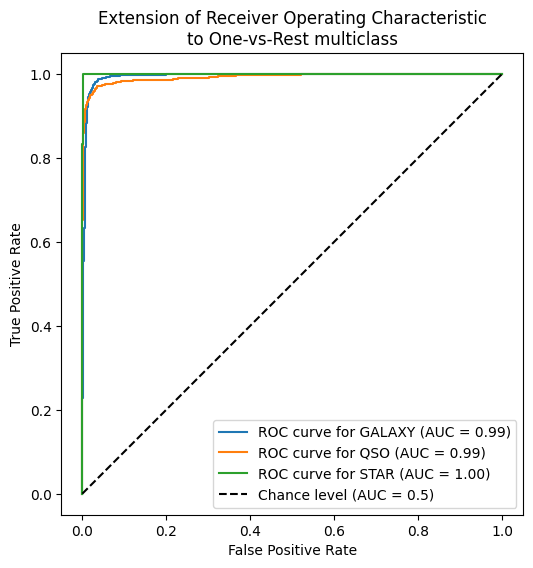

In [30]:
# Creates the AUC and ROC curve
fig, ax = plt.subplots(figsize=(6, 6))

classes_of_interest = ["GALAXY", "QSO", "STAR"]
n_classes = len(classes_of_interest)
for class_id in range(n_classes):
    RocCurveDisplay.from_predictions(
        y_true[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {classes_of_interest[class_id]}",
        ax=ax,
        plot_chance_level=(class_id == 2),
    )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()

# Releasing resources

In [31]:
conn.close()
engine.dispose()

# References

https://docs.intersystems.com/irislatest/csp/docbook/DocBook.UI.Page.cls?KEY=BPYNAT_refapi#BPYNAT_refapi_irispackage_createconn

https://community.intersystems.com/post/sqlalchemy-easiest-way-use-python-and-sql-iriss-databases

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_sql.html

https://docs.intersystems.com/irislatest/csp/docbook/DocBook.UI.Page.cls?KEY=GIML

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#plot-all-ovr-roc-curves-together